### Let's plot our most recent Torque log in python

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import osmapping
reload(osmapping)
%matplotlib inline

Import the file into pandas, and drop all rows without a GPS fix

In [5]:
fname2 = '/Users/astyler/Desktop/torqueTrackLog.csv'
trip = pd.read_csv(fname2, na_values=['-'], index_col=False, header=False, names=['GPSTime','Time','Longitude','Latitude','GPSSpeed','GPSError','Altitude','Bearing','Gx','Gy','Gz','G'])
trip = trip.dropna(subset = ['Longitude','Latitude'])
trip.head()

,GPSTime,Time,Longitude,Latitude,GPSSpeed,GPSError,Altitude,Bearing,Gx,Gy,Gz,G
285,Mon Jun 22 18:02:57 EDT 2015,22-Jun-2015 18:02:10.764,-71.092698,42.365715,0.662574,15,26.376932,240.81718,4.568137,-6.952762,1.235408,-0.123670
286,Mon Jun 22 18:02:57 EDT 2015,22-Jun-2015 18:02:11.265,-71.092698,42.365715,0.662574,15,26.376932,240.81718,5.726931,-6.655881,0.919373,-0.081043
287,Mon Jun 22 18:02:58 EDT 2015,22-Jun-2015 18:02:11.764,-71.092704,42.365760,1.000519,25,22.678742,246.36047,10.975020,-8.896853,3.782839,0.509910
288,Mon Jun 22 18:02:58 EDT 2015,22-Jun-2015 18:02:12.264,-71.092704,42.365760,1.000519,25,22.678742,246.36047,7.594408,-5.659893,4.520253,0.088812
289,Mon Jun 22 18:02:59 EDT 2015,22-Jun-2015 18:02:12.764,-71.092730,42.365793,0.570067,10,29.586119,180.74815,6.502652,-4.673482,4.223372,-0.058133


Find the Lat/Lon bounding box and create a new map from the osmapping library

In [16]:
ll = (min(trip.Longitude), min(trip.Latitude))
ur = (max(trip.Longitude), max(trip.Latitude))

mymap = osmapping.MLMap(ll,ur)

trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

Import the shapefiles from [Mapzen](https://mapzen.com/data/metro-extracts) for Boston

In [17]:
reload(osmapping)
mymap.load_shape_file('./shapefiles/boston/line.shp')
mymap.load_shape_file('./shapefiles/boston/polygon.shp')


In [18]:
mymap.shapes.shape

(541, 59)

Select most road-types and some parks for plotting

In [37]:
mymap.clear_selected_shapes()
road = {'edgecolor':'#93a1a1','lw':3, 'facecolor':'none','zorder':5};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#859900',edgecolor='none',zorder=4)

Plot the basemap and then overlay the trip trace

In [38]:

for buildingtype in ['yes', 'apartments', 'commercial', 'house', 'residential', 'university', 'church', 'garage']:
    mymap.select_shape('building',buildingtype, facecolor='none', edgecolor='#dedede', hatch='///',zorder=7)


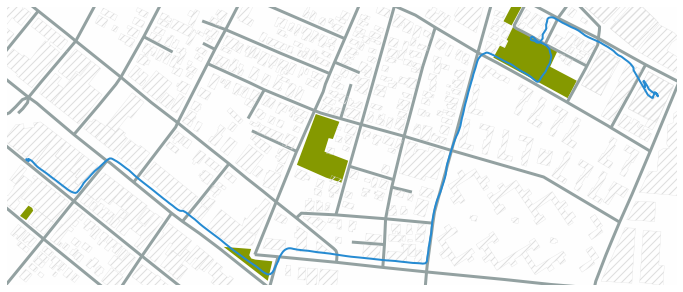

In [39]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax,fill='#fefefe')

ax.plot(trip.x, trip.y, color='#268bd2', lw=2, zorder=99);